In [1]:
"""
new mean = sqrt(at) * x0
standard deviation = sqrt(1 - alpha t) * random noise
"""

'\nnew mean = sqrt(at) * x0\nstandard deviation = sqrt(1 - alpha t) * random noise\n'

In [2]:
!pip install unet

import torch
import urllib
import PIL
from PIL import Image
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
import torch.nn as nn
from typing import Tuple
from unet import UNet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.6 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 10.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
def plot_noise_distribution(noise, predicted_noise):
    plt.hist(noise.detach().cpu().numpy().flatten(), density = True, alpha = 0.8, label = "ground truth noise")
    plt.hist(predicted_noise.detach().cpu().numpy().flatten(), density = True, alpha = 0.8, label = "predicted noise")
    plt.legend()
    plt.show()
    
def plot_noise_prediction(noise, predicted_noise):
    plt.figure(figsize=(15,15))
    f, ax = plt.subplots(1, 2, figsize = (5,5))
    ax[0].imshow(reverse_transform(noise))
    ax[0].set_title(f"ground truth noise", fontsize = 10)
    ax[1].imshow(reverse_transform(predicted_noise))
    ax[1].set_title(f"predicted noise", fontsize = 10)
    plt.show()

In [5]:
@dataclass
class Config:
    img_shape: Tuple[int, int]
    start_schedule: float
    end_schedule: float
    timestep: int

In [6]:
class DiffusionModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        
        self.width = config.img_shape[0]
        self.height = config.img_shape[1]
        self.start_schedule = config.start_schedule
        self.end_schedule = config.end_schedule
        self.timestep = config.timestep

        self.betas = torch.linspace(self.start_schedule, self.end_schedule, self.timestep)
        self.alphas = 1 - self.betas
        self.alpha_cumprod = torch.cumprod(self.alphas, axis=0)
    
    def forward(self, x_0, t, device):
        """
        x_0: (B, C, H, W)
        t: (B, )
        """
        noise = torch.randn_like(x_0)
        sqrt_alpha_cumprod_t = self.get_index_from_list(self.alpha_cumprod.sqrt(), t, x_0.shape)
        sqrt_one_miuns_alpha_prod = self.get_index_from_list(torch.sqrt(1. - self.alpha_cumprod), t, x_0.shape)

        mean = sqrt_alpha_cumprod_t.to(device) * x_0.to(device)
        variance = sqrt_one_miuns_alpha_prod.to(device) * noise.to(device)
        
        return mean + variance, noise.to(device)

    @torch.no_grad()
    def backward(self, x, t, model, **kwargs):
        betas_t = self.get_index_from_list(self.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alpha_cumprod), t, x.shape)
        sqrt_recip_alphas_t = self.get_index_from_list(torch.sqrt(1.0 / self.alphas), t, x.shape)
        mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t, **kwargs).sample / sqrt_one_minus_alphas_cumprod_t)
        posterior_variance_t = betas_t

        if t == 0:
            return mean
        else:
            noise = torch.randn_like(x)
            variance = torch.sqrt(posterior_variance_t) * noise 
            return mean + variance

    @staticmethod
    def get_index_from_list(values, t, x_shape):
        batch_size = t.shape[0]
        """
        pick values according from vals
        """
        result = values.gather(-1, t.cpu())
        """
        if shape of x -> (5, 3, 64, 64)
                -> len(x_shape) = 4
                -> len(x_shape) - 1 = 3
        """
        return result.view(batch_size, *([1] * (len(x_shape) - 1))).to(t.device)


In [7]:
def get_sample_image() -> PIL.Image.Image:
    url = 'https://media.istockphoto.com/id/1703754111/it/foto/tramonto-drammatico-cielo-nuvole.jpg?s=612x612&w=0&k=20&c=ION4SEQMCALUBj2_poIsx8cohiTooK5hXvZPVS1w-Bo='
    filename = 'sunset.jpg'
    urllib.request.urlretrieve(url, filename)
    return PIL.Image.open(filename)


In [8]:
# x0 = torch.randn(2, 3, IMG_WIDTH, IMG_HEIGHT)

In [9]:
config = Config(
    img_shape=(32, 32),
    start_schedule=0.0001,
    end_schedule=0.02,
    timestep=300
)

In [10]:
model = DiffusionModel(config).to(device)

In [11]:
def forward_diffusion(x0, t, betas = torch.linspace(0.0, 1.0, 5)):
    noise = torch.rand_like(x0)
    
    alphas = 1 - betas
    alpha_hat = torch.cumprod(alphas, axis=-1)
    result = alpha_hat.gather(-1, t)
    result = result.reshape(-1, 1, 1, 1)
    # print(alpha_hat.sqrt().size())
    # print(x0.size())
    mean = result.sqrt() * x0
    variance = torch.sqrt(1-result) * noise
    x_t = mean + variance
    return x_t, noise

In [12]:
betas = torch.tensor([0.05, 0.1, 0.15, 0.2, 0.25]) # betas = number noise added to ever diffusion step 

In [13]:
url = 'https://media.istockphoto.com/id/1703754111/it/foto/tramonto-drammatico-cielo-nuvole.jpg?s=612x612&w=0&k=20&c=ION4SEQMCALUBj2_poIsx8cohiTooK5hXvZPVS1w-Bo='
filename = "sunset.png"
urllib.request.urlretrieve(url, filename)

('sunset.png', <http.client.HTTPMessage at 0x7b3d87a35310>)

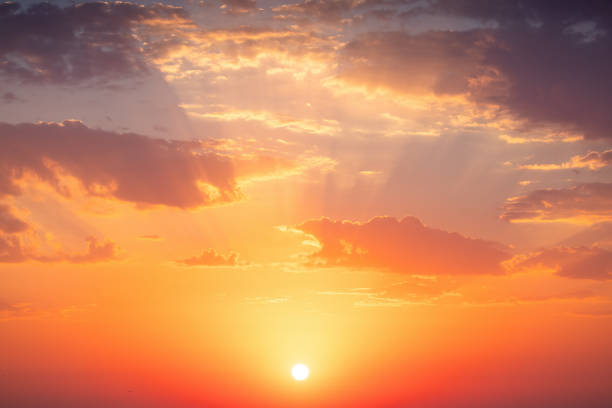

In [14]:
image = Image.open(filename)
image

In [15]:
transform = transforms.Compose([ #PIL -> torch
    transforms.Resize((config.img_shape[0], config.img_shape[1])),
    transforms.ToTensor(), # 0 to 1
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # [-1,1]
    #scale from -1 to 1, layer norm
    # transforms.Lambda(lambda t: (t*2) - 1)
])

reverse_transform = transforms.Compose([ #torch -> PIL
    transforms.Lambda(lambda t: (t.clamp(-1, 1) + 1) / 2),  # [-1,1] -> [0,1]
    transforms.Lambda(lambda t: t.permute(1, 2, 0)), #C,H,W->H,W,C
    transforms.Lambda(lambda t: t * 255.),
    transforms.Lambda(lambda t: t.detach().cpu().numpy().astype(np.uint8)),
    transforms.ToPILImage()
])

In [16]:
pil_image = get_sample_image()
torch_image = transform(pil_image)
print(f"torch_image shape: {torch_image.shape}")


torch_image shape: torch.Size([3, 32, 32])


torch_image_batch shape: torch.Size([5, 3, 32, 32])
t: tensor([  0,  74, 149, 224, 299])
t shape: torch.Size([5])
noise image: torch.Size([5, 3, 32, 32])
noisy image: [[-0.5307031  -0.49486074 -0.49718451 ... -0.61633044 -0.6384023
  -0.660749  ]
 [-0.5316947  -0.5326864  -0.5034714  ... -0.5391456  -0.5117763
  -0.57828635]
 [-0.50002134 -0.46739703 -0.42478403 ... -0.44777277 -0.39705387
  -0.4632479 ]
 ...
 [ 0.3542876   0.4185976   0.52024865 ...  0.43368965  0.35577282
   0.29178965]
 [ 0.21290648  0.305995    0.3478533  ...  0.30408677  0.2408139
   0.17150521]
 [ 0.05699642  0.10028555  0.18807498 ...  0.13183437  0.05479699
   0.00153004]]
just noise shape: torch.Size([5, 3, 32, 32])
noisy: [[-0.9159822  -0.46888325  0.08296854 ... -0.06749354 -0.7060746
  -0.58792824]
 [ 1.3375031   0.45412582  1.0227615  ... -0.19173649  0.9765411
  -0.1844417 ]
 [-0.20068756 -0.07536818  1.0487436  ...  1.1026874   0.68468946
   1.1237233 ]
 ...
 [-1.8241322  -2.451548   -0.9135913  ...  0.6

<Figure size 1500x1500 with 0 Axes>

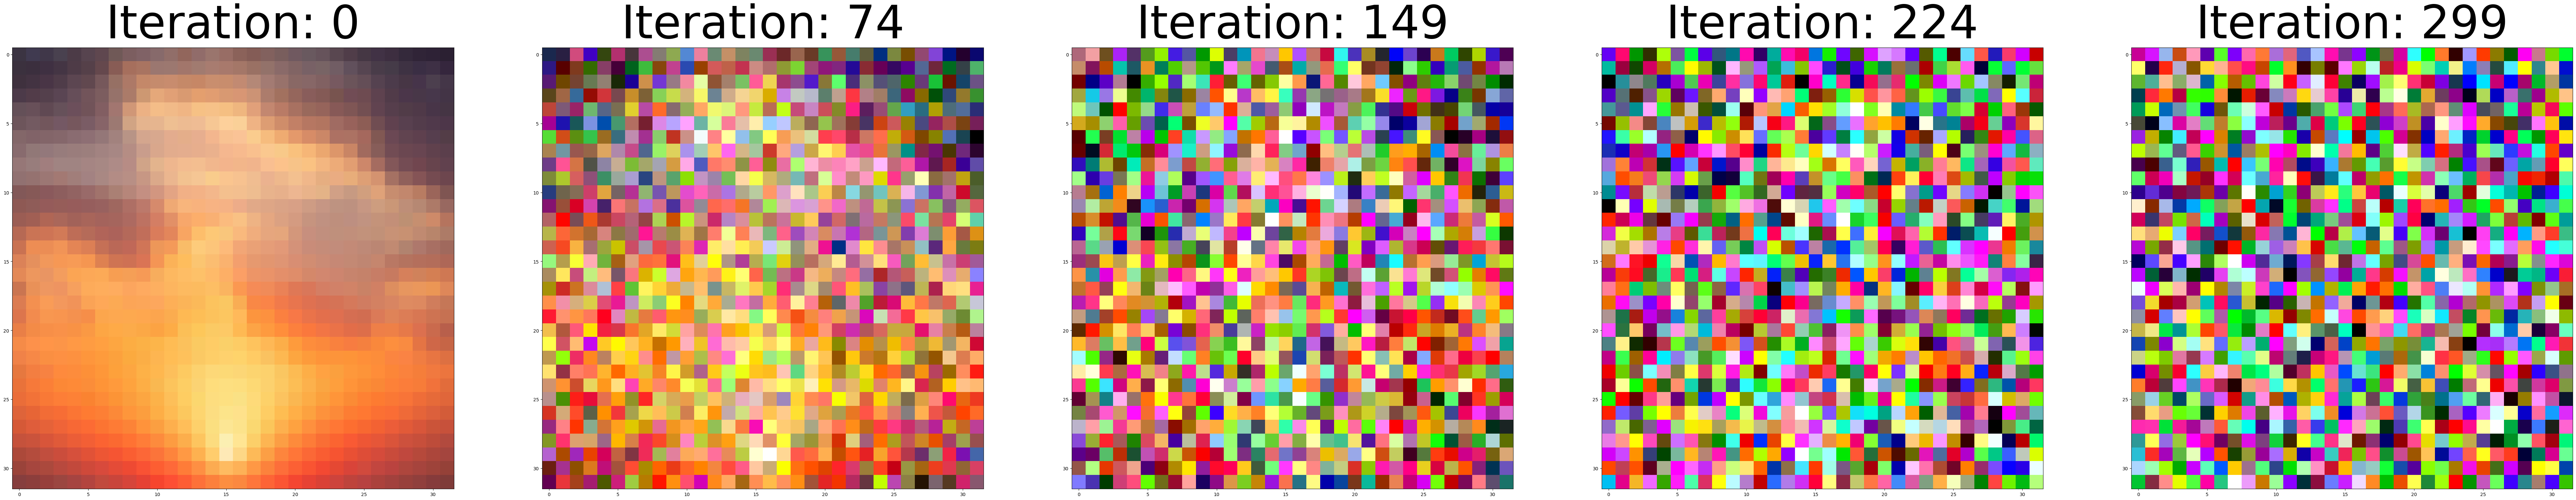

In [17]:
NO_DISPLAY_IMAGES = 5
torch_image_batch = torch.stack([torch_image] * NO_DISPLAY_IMAGES)
print(f"torch_image_batch shape: {torch_image_batch.shape}")

t = torch.linspace(0, model.timestep - 1, NO_DISPLAY_IMAGES).long()
print(f"t: {t}")
print(f"t shape: {t.shape}")

noisy_image_batch, noise = model.forward(torch_image_batch, t, device)
print(f"noise image: {noisy_image_batch.shape}")
print("noisy image: " + str(noisy_image_batch[0][0].cpu().numpy()))
print(f"just noise shape: {noise.shape}")
print("noisy: " + str(noise[0][0].cpu().numpy()))
# print(f"noisy batch image shape: {noisy_image_batch.shape}")


plt.figure(figsize=(15,15))
f, ax = plt.subplots(1, NO_DISPLAY_IMAGES, figsize = (100,100))

# for idx in range(NO_DISPLAY_IMAGES):    
#     # ax[idx].imshow(reverse_transform(single_image))

#     single_image = noisy_image_batch[idx].cpu() (C, H, W)

#     # If 4D (B, C, H, W),  [0] -> (C, H, W)
#     # if single_image.dim() == 4:
#         # single_image = single_image[0]

#         # ax[idx].imshow(reverse_transform(single_image))

#     # single_image = image.squeeze(0) if image.dim() == 4 else image
#     ax[idx].imshow(reverse_transform(single_image))

#     # ax[idx].imshow(reverse_transform(image))
#     ax[idx].set_title(f"Iteration: {t[idx].item()}", fontsize = 100)
# plt.show()

for idx, image in enumerate(noisy_image_batch):
    ax[idx].imshow(reverse_transform(image.cpu()))
    ax[idx].set_title(f"Iteration: {t[idx].item()}", fontsize = 100)
plt.show()


In [18]:
t = torch.tensor([0, 1, 2, 3, 4])
batch_images = torch.stack([torch_image] * 5)
noisy_image, _ = forward_diffusion(batch_images, t)
# plt.imshow(reverse_transform(noisy_image))

In [19]:
# for img in noisy_image:
#     print(img.size())
#     img = reverse_transform(img)
#     plt.imshow(img)
#     plt.show(img)

In [20]:
from diffusers import UNet2DModel

2025-07-30 23:52:48.190328: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753919568.384120      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753919568.433686      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [39]:
unet = UNet2DModel(sample_size=32, in_channels=3, out_channels=3, 
                   layers_per_block=1, block_out_channels=(32, 64),
                   down_block_types=("DownBlock2D", "DownBlock2D"),
                   up_block_types=("UpBlock2D", "UpBlock2D"), num_class_embeds=10).to(device)

def init_weights(m):
    if isinstance(m, torch.nn.Conv2d):
        torch.nn.init.normal_(m.weight, 0, 0.02)
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)

unet.apply(init_weights)

EPOCHES = 1000
PRINTHZ = 500
LR = 4e-3
BATCH = 128
# optimizer = torch.optim.AdamW(unet.parameters(), lr=LR, weight_decay=0.01)
optimizer = torch.optim.Adam(unet.parameters(), lr=LR)

In [22]:
import inspect
print(inspect.signature(unet.forward))

(sample: torch.Tensor, timestep: Union[torch.Tensor, float, int], class_labels: Optional[torch.Tensor] = None, return_dict: bool = True) -> Union[diffusers.models.unets.unet_2d.UNet2DOutput, Tuple]


In [23]:
def debug_reverse_transform(tensor):
    print(f"Input tensor range: [{tensor.min():.3f}, {tensor.max():.3f}]")
    
    tensor_min = tensor.min()
    tensor_max = tensor.max()
    step1 = (tensor - tensor_min) / (tensor_max - tensor_min)  # Normalize to [0,1]
    print(f"After normalize: [{step1.min():.3f}, {step1.max():.3f}]")
    
    step2 = step1.permute(1, 2, 0)  # C,H,W -> H,W,C
    step3 = step2 * 255.0
    step4 = step3.detach().cpu().numpy().astype(np.uint8)
    
    return step4


debug_reverse_transform(torch_image)

Input tensor range: [-0.749, 1.000]
After normalize: [0.000, 1.000]


array([[[ 33,  24,  42],
        [ 37,  30,  52],
        [ 36,  27,  48],
        ...,
        [ 19,   5,  28],
        [ 17,   2,  25],
        [ 13,   0,  20]],

       [[ 29,  17,  35],
        [ 30,  17,  36],
        [ 34,  18,  37],
        ...,
        [ 30,  16,  38],
        [ 33,  19,  41],
        [ 25,  11,  33]],

       [[ 36,  19,  35],
        [ 41,  22,  38],
        [ 45,  25,  42],
        ...,
        [ 42,  27,  46],
        [ 50,  37,  56],
        [ 40,  26,  46]],

       ...,

       [[163,  48,  32],
        [173,  50,  33],
        [186,  52,  33],
        ...,
        [171,  46,  32],
        [160,  43,  32],
        [149,  42,  32]],

       [[141,  40,  30],
        [150,  43,  33],
        [162,  44,  34],
        ...,
        [152,  41,  33],
        [141,  38,  32],
        [132,  36,  29]],

       [[117,  34,  30],
        [125,  36,  33],
        [134,  38,  34],
        ...,
        [126,  35,  33],
        [117,  32,  30],
        [108,  29,  29]]

Epoch 0:
  Noisy image: [-4.073, 4.430]
  True noise:  [-4.606, 4.639]
  Pred noise:  [-1.109, 1.086]
  Loss: 1.028988
  Pred std: 0.195, True std: 1.001
  Std ratio: 0.195


<Figure size 1500x1500 with 0 Axes>

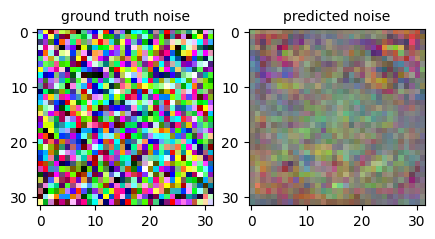

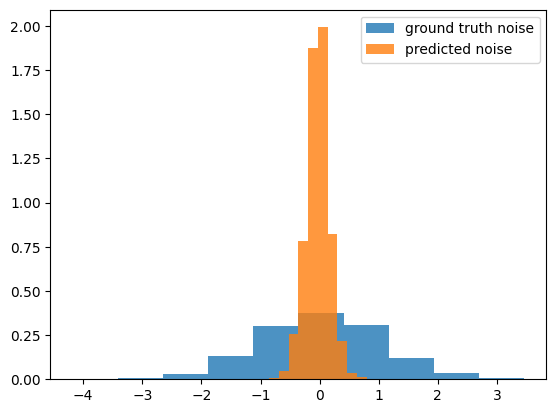

Epoch 20:
  Noisy image: [-4.539, 4.002]
  True noise:  [-5.080, 4.595]
  Pred noise:  [-5.479, 4.599]
  Loss: 0.100462
  Pred std: 0.993, True std: 0.998
  Std ratio: 0.995


<Figure size 1500x1500 with 0 Axes>

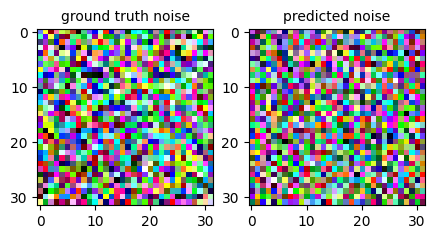

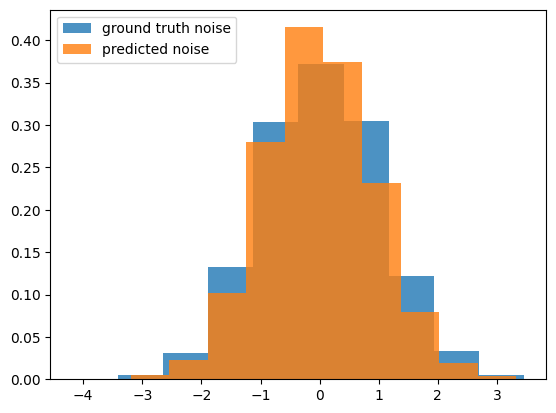

Epoch 40:
  Noisy image: [-4.010, 3.817]
  True noise:  [-4.906, 4.860]
  Pred noise:  [-4.194, 4.723]
  Loss: 0.061091
  Pred std: 0.975, True std: 1.001
  Std ratio: 0.975


<Figure size 1500x1500 with 0 Axes>

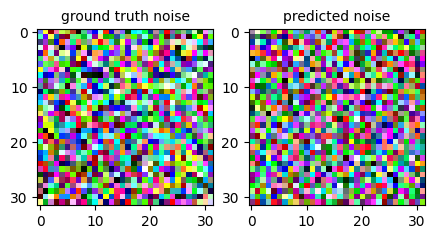

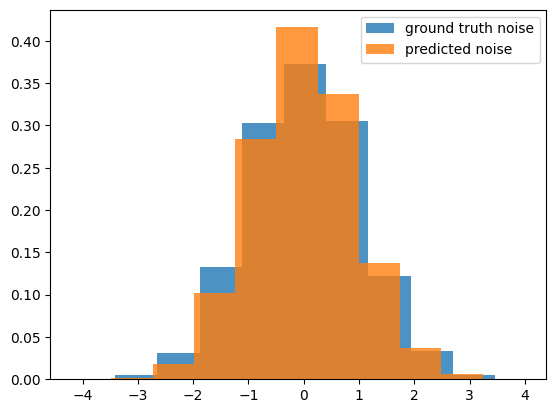

Epoch 60:
  Noisy image: [-4.392, 4.132]
  True noise:  [-4.567, 4.271]
  Pred noise:  [-4.576, 4.595]
  Loss: 0.046879
  Pred std: 0.969, True std: 1.000
  Std ratio: 0.969


<Figure size 1500x1500 with 0 Axes>

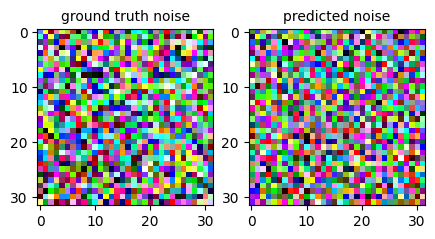

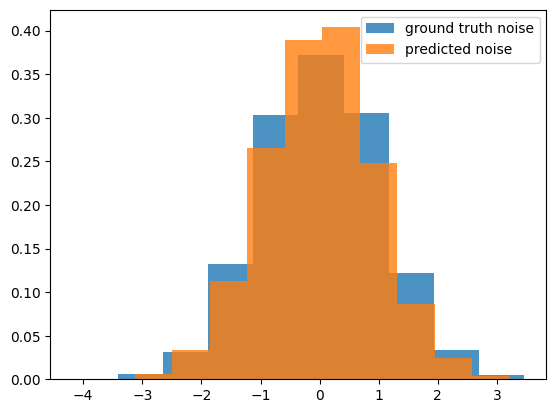

Epoch 80:
  Noisy image: [-3.985, 4.834]
  True noise:  [-4.679, 5.081]
  Pred noise:  [-4.468, 4.529]
  Loss: 0.040715
  Pred std: 0.978, True std: 0.999
  Std ratio: 0.979


<Figure size 1500x1500 with 0 Axes>

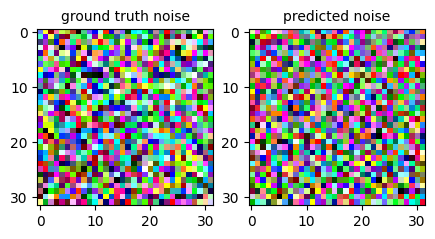

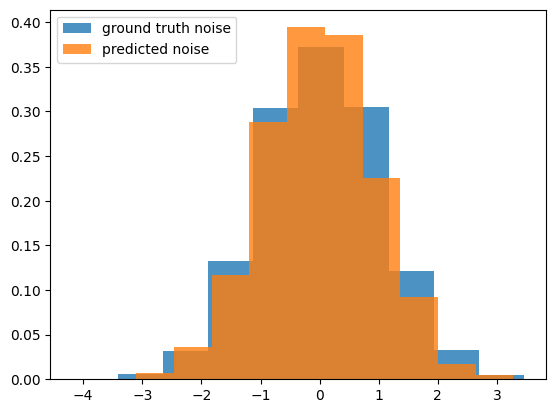

Epoch 100:
  Noisy image: [-3.736, 4.310]
  True noise:  [-5.035, 4.542]
  Pred noise:  [-4.614, 4.591]
  Loss: 0.033048
  Pred std: 0.984, True std: 1.001
  Std ratio: 0.983


<Figure size 1500x1500 with 0 Axes>

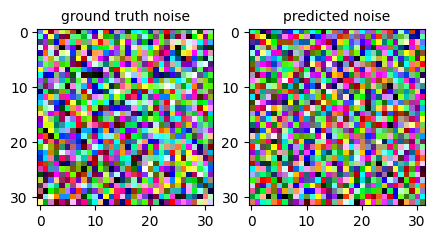

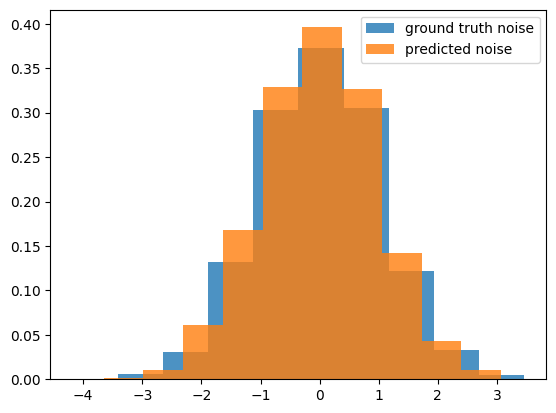

Epoch 120:
  Noisy image: [-4.222, 4.734]
  True noise:  [-4.594, 4.847]
  Pred noise:  [-4.377, 4.799]
  Loss: 0.029272
  Pred std: 0.975, True std: 1.001
  Std ratio: 0.974


<Figure size 1500x1500 with 0 Axes>

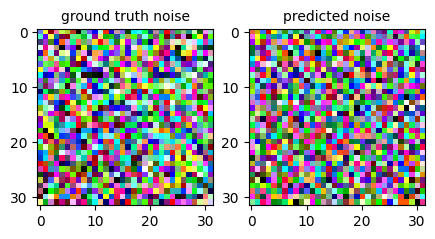

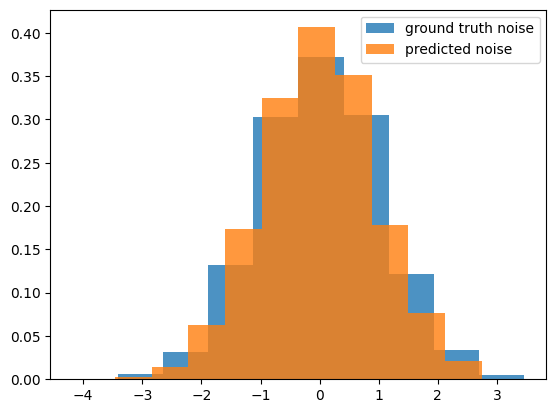

Epoch 140:
  Noisy image: [-3.954, 3.962]
  True noise:  [-4.511, 4.351]
  Pred noise:  [-4.366, 4.195]
  Loss: 0.023466
  Pred std: 0.990, True std: 1.001
  Std ratio: 0.989


<Figure size 1500x1500 with 0 Axes>

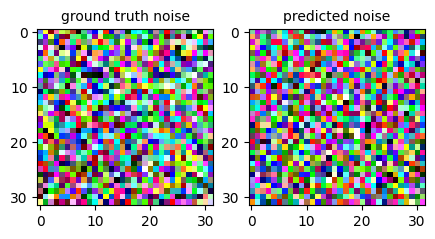

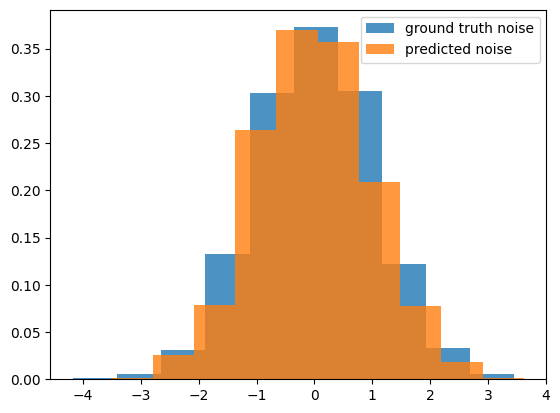

Epoch 160:
  Noisy image: [-4.162, 4.503]
  True noise:  [-4.567, 4.899]
  Pred noise:  [-4.669, 4.638]
  Loss: 0.019212
  Pred std: 1.001, True std: 0.999
  Std ratio: 1.002


<Figure size 1500x1500 with 0 Axes>

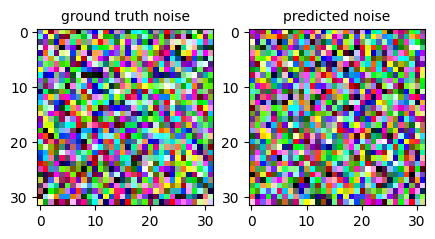

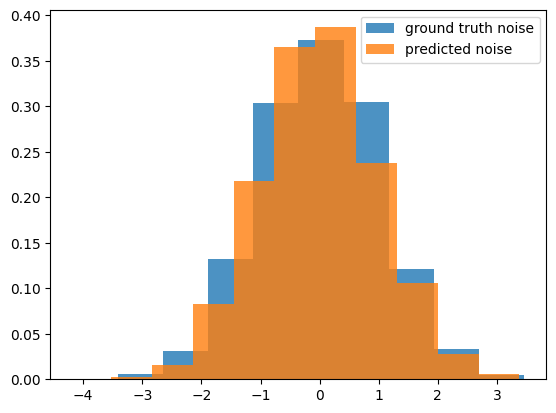

Epoch 180:
  Noisy image: [-3.750, 4.565]
  True noise:  [-4.524, 4.571]
  Pred noise:  [-4.488, 4.680]
  Loss: 0.016999
  Pred std: 0.995, True std: 1.000
  Std ratio: 0.995


<Figure size 1500x1500 with 0 Axes>

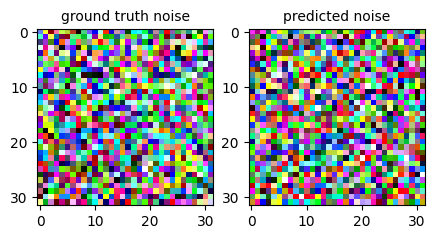

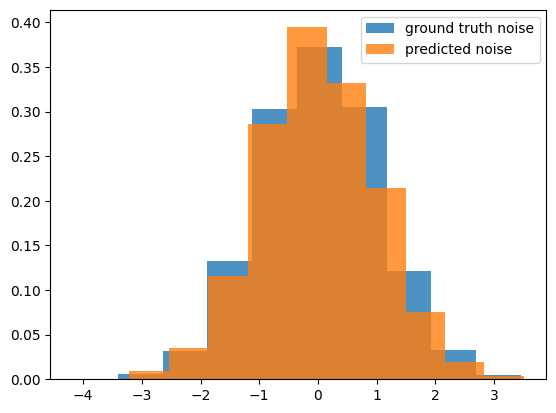

In [41]:
model = DiffusionModel(config).to(device)
EPOCHES = 200

# torch.compile
PRINTHZ = 20


x0 = torch_image
batch_size = torch.stack([x0] * BATCH).to(device)
t = torch.randint(0, model.timestep, (BATCH, )).long().to(device)

for epoch in range(EPOCHES):
    """
    x0, input batches
    t -> sample uniformed number of diffusion
    """
    # x0 = torch_image
    # batch_size = torch.stack([x0] * BATCH).to(device)
    # t = torch.randint(0, model.timestep, (BATCH, )).long().to(device)
    loss_epoch = []
    
    noisy_image, torch_noise = model.forward(batch_size, t, device)
    # print(noisy_image.shape)
    predicted_noise = unet(noisy_image, t, class_labels=label.to(device)).sample

    
    optimizer.zero_grad()
    loss = torch.nn.functional.mse_loss(predicted_noise, torch_noise)
    torch.nn.utils.clip_grad_norm_(unet.parameters(), 1.0)  # Add this line
    loss_epoch.append(loss)

    loss.backward()
    optimizer.step()
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=1000)
    if epoch % PRINTHZ == 0:
        with torch.no_grad():
        # print(f"epoch: {epoch}, loss: {loss}, ")
            print(f"Epoch {epoch}:")
            print(f"  Noisy image: [{noisy_image.min():.3f}, {noisy_image.max():.3f}]")
            print(f"  True noise:  [{torch_noise.min():.3f}, {torch_noise.max():.3f}]")
            print(f"  Pred noise:  [{predicted_noise.min():.3f}, {predicted_noise.max():.3f}]")
            print(f"  Loss: {loss:.6f}")
            pred_std = predicted_noise.std().item()
            true_std = torch_noise.std().item()
            print(f"  Pred std: {pred_std:.3f}, True std: {true_std:.3f}")
            print(f"  Std ratio: {pred_std/true_std:.3f}")  # Should be close to 1.0
            plot_noise_prediction(noise[0], predicted_noise[0])
            plot_noise_distribution(noise[0], predicted_noise[0])

Input tensor range: [-3.693, 3.385]
After clamp+normalize: [0.000, 1.000]
After permute: torch.Size([32, 32, 3])
After scale: [0.000, 255.000]
After numpy: [0, 255], shape: (32, 32, 3)


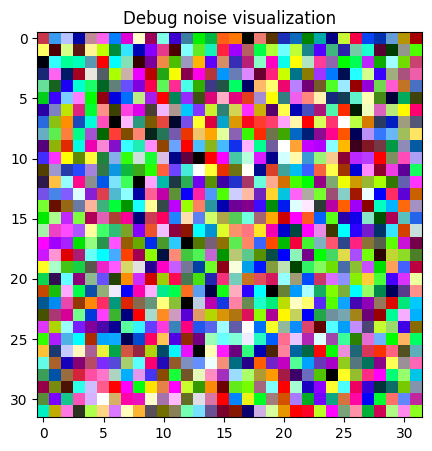

In [25]:
def debug_reverse_transform(tensor):
    print(f"Input tensor range: [{tensor.min():.3f}, {tensor.max():.3f}]")
    
    step1 = (tensor.clamp(-1, 1) + 1) / 2  # [-1,1] -> [0,1]
    print(f"After clamp+normalize: [{step1.min():.3f}, {step1.max():.3f}]")
    
    step2 = step1.permute(1, 2, 0)  # C,H,W -> H,W,C
    print(f"After permute: {step2.shape}")
    
    step3 = step2 * 255.0
    print(f"After scale: [{step3.min():.3f}, {step3.max():.3f}]")
    
    step4 = step3.detach().cpu().numpy().astype(np.uint8)
    print(f"After numpy: [{step4.min()}, {step4.max()}], shape: {step4.shape}")
    
    return step4

test_img = debug_reverse_transform(torch_noise[0].detach())
plt.figure(figsize=(5, 5))
plt.imshow(test_img)
plt.title("Debug noise visualization")
plt.show()

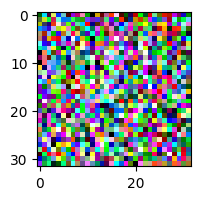

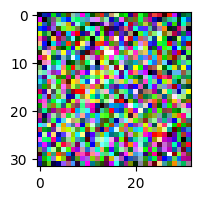

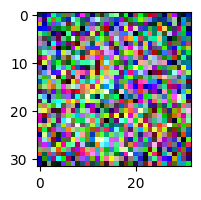

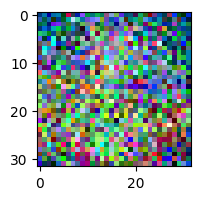

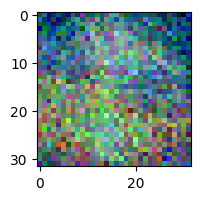

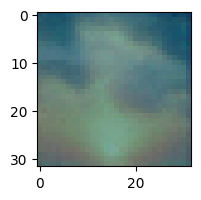

In [26]:
with torch.no_grad():
    img = torch.randn((1, 3) + (model.width, model.height)).to(device)
    for i in reversed(range(model.timestep)):
        t = torch.full((1,), i, dtype=torch.long, device=device)
        img = model.backward(img, t, unet.eval())
        if i % 50 == 0:
            plt.figure(figsize=(2,2))
            plt.imshow(reverse_transform(img[0]))
            plt.show()

In [32]:
import torchvision 
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=4, drop_last=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4, drop_last=True)


---
Epoch: 0 | Train Loss 0.06306268718953316 | Val Loss 0.06348904026433444


<Figure size 1500x1500 with 0 Axes>

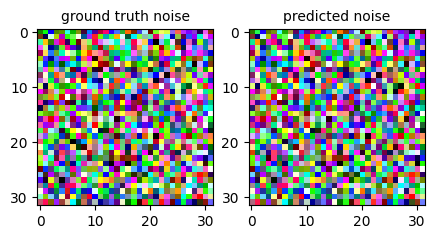

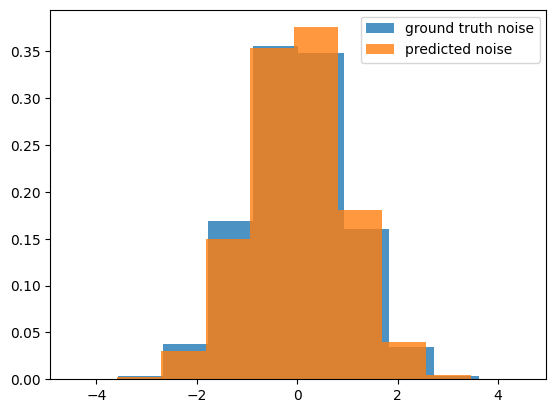

KeyboardInterrupt: 

In [48]:
for epoch in range(EPOCHES):
    mean_epoch_loss = []
    mean_epoch_loss_val = []
    for batch, label in trainloader:
        t = torch.randint(0, model.timestep, (BATCH,)).long().to(device)
        batch = batch.to(device)
        batch_noisy, noise = model.forward(batch, t, device) 
        predicted_noise = unet(batch_noisy, t, class_labels = label.to(device)).sample

        optimizer.zero_grad()
        loss = torch.nn.functional.mse_loss(noise, predicted_noise) 
        mean_epoch_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
    for batch, label in testloader:

        t = torch.randint(0, model.timestep, (BATCH,)).long().to(device)
        batch = batch.to(device)

        batch_noisy, noise = model.forward(batch, t, device) 
        predicted_noise = unet(batch_noisy, t, class_labels = label.to(device)).sample

        loss = torch.nn.functional.mse_loss(noise, predicted_noise) 
        mean_epoch_loss_val.append(loss.item())

    if epoch % PRINTHZ == 0:
        print('---')
        print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)} | Val Loss {np.mean(mean_epoch_loss_val)}")
        with torch.no_grad():
            plot_noise_prediction(noise[0], predicted_noise[0])
            plot_noise_distribution(noise, predicted_noise)
                
        torch.save(unet.state_dict(), f"epoch: {epoch}")


In [53]:
# unet = UNet(class_labels=True)
unet.load_state_dict(torch.load(("epoch: 0")))


<All keys matched successfully>

In [54]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [55]:
NUM_CLASSES = len(classes)
NUM_DISPLAY_IMAGES = 5

In [60]:
torch.manual_seed(16)

plt.figure(figsize=(15,15))
f, ax = plt.subplots(NUM_CLASSES, NUM_DISPLAY_IMAGES, figsize = (100,100))

for c in range(NUM_CLASSES):
    imgs = torch.randn((NUM_DISPLAY_IMAGES, 3) + (model.width, model.height)).to(device)
    for i in reversed(range(model.timestep)):
        t = torch.full((1,), i, dtype=torch.long, device=device)
        labels = torch.tensor([c] * NUM_DISPLAY_IMAGES).to(device)
        imgs = model.backward(x=imgs, t=t, model=unet.eval().to(device), class_labels = labels)
    for idx, img in enumerate(imgs):
        ax[c][idx].imshow(reverse_transform(img))
        ax[c][idx].set_title(f"Class: {classes[c]}", fontsize = 100)
        
plt.show()


<Figure size 1500x1500 with 0 Axes>